<!--<div style=float:right><img src="assets/img/applied-logo.png" width=100 style="margin: 0px 20px"></img></div>-->

##### Applied AI Internal Demo Project
## Car Emissions Study

This subset (9x series) of notebooks was created for publication in a [series of blogposts for Applied AI](http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/). They are part of a wider project primarily serving as a coherent collection of my preferred techniques for data preparation & analysis and Bayesian inference in Python.

A set of notebooks designed to investigate car emissions data from the PoV of the [Volkswagen Emissions Scandal](https://en.wikipedia.org/wiki/Volkswagen_emissions_scandal) which seems to have meaningfully [damaged their sales](http://www.usatoday.com/story/money/cars/2015/12/01/emissions-scandal-crushes-volkswagen-sales-november/76605062/). The motivation is to investigate the data and see if we can see any unsual behaviour in Volkswagen.

Using data from the [UK VCA (Vehicle Type Approval)](http://www.dft.gov.uk/vca/) [Car Fuel and Emissions Information](http://carfueldata.direct.gov.uk) for August 2015. Dataset available [here](http://carfueldata.direct.gov.uk/downloads/download.aspx?rg=aug2015) and also included in the repo since it's small.


    
# 93_HierarchicalLinearRegression

#### Demonstrate pooling and hierarchical linear regression

      
+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    + [Prepare Dataset](#Prepare-Dataset)


+ [Pooled Model](#Pooled-Model)


+ [Unpooled Model](#Unpooled-Model)


+ [Partially-Pooled Model](#Partially-Pooled-Model)


+ [Hierarchical Model](#Hierarchical-Model)



**Notes:**

+ Python 3.5 project using the latest available [PyMC3](https://github.com/pymc-devs/pymc3)
+ Developed using ContinuumIO Anaconda distribution on a Macbook Pro 3GHz i7, 16GB RAM, OSX 10.10.5.
+ If execution becomes unstable or Theano throws weird errors, try clearing the cache $> theano-cache clear and rerunning the notebook.


**Package Requirements (shown as a conda-env YAML):**
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
channels:
  - defaults
dependencies:
  - python=3.5
  - jupyter
  - ipywidgets
  - numpy
  - scipy
  - matplotlib=1.4.3
  - pandas
  - scikit-learn
  - seaborn
  - patsy  
  - pip

$> conda env create --file conda_env_pymc3_examples.yml
$> source activate pymc3_examples
$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3
```

# Setup

Nothing especially interesting in this Setup section, just loading the packages and data we need

In [36]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [2]:
# general packages
import warnings
warnings.filterwarnings('ignore')
import regex as re

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy import optimize

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 

from ipywidgets import interactive, fixed

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)
storename = 'data/store_01.h5'

## Local Functions

In [3]:
def custom_describe(df, nrows=3, nfeats=20):
    ''' Conv fn: concat transposed topN rows, numerical desc & dtypes '''

    print(df.shape)
    rndidx = np.random.randint(0,len(df),nrows)
    dfdesc = df.describe().T

    for col in ['mean','std']:
        dfdesc[col] = dfdesc[col].apply(lambda x: np.round(x,2))
 
    dfout = pd.concat((df.iloc[rndidx].T, dfdesc, df.dtypes),axis=1, join='outer')
    dfout = dfout.loc[df.columns.values]
    dfout.rename(columns={0:'dtype'}, inplace=True)
    
    # add count nonNAN, min, max for string cols
    dfout['count'] = df.shape[0] - df.isnull().sum()
    dfout['min'] = df.min().apply(lambda x: x[:6] if type(x) == str else x)
    dfout['max'] = df.max().apply(lambda x: x[:6] if type(x) == str else x)
    
    return dfout.iloc[:nfeats,:]



def trace_median(x):
    return pd.Series(np.median(x,0), name='median')


def plot_traces(trcs, retain=1000, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
    
    ax = pm.traceplot(trcs[-retain:], varnames=varnames, figsize=(12,nrows*1.4)
        ,lines={k: v['mean'] for k, v in 
            pm.df_summary(trcs[-retain:],varnames=varnames).iterrows()})

    # don't label the nested traces (a bit clumsy this: consider tidying)
    dfmns = pm.df_summary(trcs[-retain:], varnames=varnames)['mean'].reset_index()
    dfmns.rename(columns={'index':'featval'}, inplace=True)
    dfmns = dfmns.loc[dfmns['featval'].apply(lambda x: re.search('__[1-9]{1,}', x) is None)]
    dfmns['draw'] = dfmns['featval'].apply(lambda x: re.search('__0{1}$', x) is None)
    dfmns['pos'] = np.arange(dfmns.shape[0])
    dfmns.set_index('pos', inplace=True)
    
    for i, r in dfmns.iterrows():
        if r['draw']:
            ax[i,0].annotate('{:.2f}'.format(r['mean']), xy=(r['mean'],0)
                    ,xycoords='data', xytext=(5,10)
                    ,textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')    


## Load Data

In [4]:
store = pd.HDFStore(storename)
df = store['/clean']
store.close()

## Prepare Dataset

This dataset allows us to ask if there's any interesting patterns in NOx emissions: for cars made by the Volkswagen group

+ `emissions_nox_mgkm`

... according to a handful of exogenous variables:

+ `mfr_owner_is_vw, transmission, fuel_type_smpl, is_tdi`
+ `engine_capacity, metric_combined, metric_extra_urban, metric_urban_cold`



##### Declare feats for use

In [5]:
fts_cat = ['mfr_owner','mfr','model','trans','fuel_type','is_tdi']
fts_num = ['metric_combined','metric_extra_urban','metric_urban_cold'
           ,'engine_capacity','emissions_co_mgkm']
ft_endog = 'emissions_nox_mgkm'

##### Exclude outliers

In [6]:
dfi = df.loc[df['mcd_outlier']==0]
dfi.shape

(2644, 21)

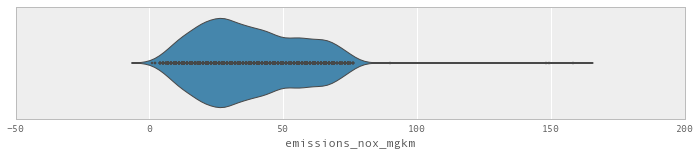

In [7]:
## also exclude 3 high-value outliers in the endogenous feat

f, ax1d = plt.subplots(1,1,figsize=(12,2))
_ = sns.violinplot(x=ft_endog, data=dfi, ax=ax1d, inner='point')

In [8]:
dfi = dfi.loc[dfi[ft_endog]<=100].copy()
dfi.shape

(2641, 21)

##### Standardize the dataset according to Gelman 1 / (2 * sd)

Divide by 2 standard deviations in order to put the variance of a normally distributed variable nearer to the variance range of a binary variable. See http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf for more info.

In [9]:
dfs = pd.concat((dfi[ft_endog], dfi[fts_cat]
    ,((dfi[fts_num] - dfi[fts_num].mean(0)) / (2 * dfi[fts_num].std(0)))),1)
# custom_describe(dfs)

## Basic Description

In [10]:
custom_describe(dfs, 2)

(2641, 12)


,2631,1662,count,mean,std,min,25%,50%,75%,max,dtype
emissions_nox_mgkm,30,56,2641,37.27,18.23,1,23,35,52,90,float64
mfr_owner,geely,daimler-ag,2641,NaN,NaN,aston,NaN,NaN,NaN,volksw,object
mfr,volvo,mercedes-benz,2641,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
model,"v60, my16","c-class saloon, model year 2015",2641,NaN,NaN,1 seri,NaN,NaN,NaN,zafira,object
trans,manual,auto,2641,NaN,NaN,auto,NaN,NaN,NaN,semiau,object
fuel_type,petrol,diesel,2641,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
is_tdi,False,False,2641,0.11,0.32,False,0,0,0,True,bool
metric_combined,0.0398752,-0.309993,2641,-0.00,0.50,-0.686775,-0.336906,-0.148516,0.17444,2.48895,float64
metric_extra_urban,-0.00561065,-0.366042,2641,0.00,0.50,-0.886664,-0.325994,-0.125754,0.194629,2.79774,float64
metric_urban_cold,0.067301,-0.268727,2641,0.00,0.50,-0.67196,-0.319131,-0.151117,0.168109,2.67152,float64


**Observe:**

+ The dataset is 2641 rows, with 12 features.
+ These are observations of car emissions tests, one row per car.
+ You can read off the basic distributional statistics of the features in the table above. Numeric features have been standardized according to [Gelman's 2sd principle](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf).
+ I have selected these particular 10 features to work with. Some are derivatives of original features.

We have the following features:

```
+ Categoricals:
    + `trans`     - the car transmission, simplified to 'auto', 'semiauto', 'manual'
    + `fuel_type` - the car's power supply, simplified to 'petrol', 'diesel', 'hybrid'
    + `model`     - the car model
    + `mfr`       - the car manufacturer
    + `mfr_owner` - the parent company of the car manufacturer

+ Booleans:
    + `is_tdi`    - (processed feature) if the car engine type is a turbo diesel
    
+ Numerics:
    + `metric_combined`    - a score for fuel efficiency in combined driving
    + `metric_extra_urban` - a score for fuel efficiency in an extra-urban driving
    + `metric_urban_cold`  - a score for fuel efficiency in an urban setting, cold start
    + `emissions_co_mgkm`  - a count of CO particulates emitted mg/km
    
+ Numeric endogenous feature:
    + `emissions_nox_mgkm` - a count of NOx particulates emitted mg/km    
```

For the purposes of this Notebook, the final feature mentioned `emissions_nox_mgkm` will be used as the _endogenous_ / _dependent_ / _output_ feature of the linear models. All other features may be used as _exogenous_ / _independent_ / _input_ features.

##### Label encode `mfr` and `mfr_owner`

In [11]:
le = LabelEncoder()
dfs['mfr_enc'] = le.fit_transform(dfs['mfr'])
dfs['mfr_owner_enc'] = le.fit_transform(dfs['mfr_owner'])

n_mfr_owner_enc = dfs['mfr_owner_enc'].max()+1
n_mfr_enc = dfs['mfr_enc'].max()+1

## Reduce features

In the previous Notebook, I used a Lasso model for feature reduction. I'll broadly follow the results of that exercise here and use the following features for modelling, I include `emissions_co_mgkm` just to demonstrate a continuous feature in there.

Note: I will use the `glm` model specification for the pooled model. I will have to manually specify the unpooled, partially-pooled and hierarchical models.

In [12]:
fml_pooled = '{} ~ '.format(ft_endog) + ' + '.join(
    ['fuel_type','is_tdi','emissions_co_mgkm'])
print(fml_pooled)

emissions_nox_mgkm ~ fuel_type + is_tdi + emissions_co_mgkm


---

# Pooled Model

Pool (ignore) the `mfr` feature.  

$$y_{m} \sim \beta x_{m} + \epsilon$$

where:  
$m \in manufacturer$

I'll attempt to robustly handle outliers this time by using a Student-T distribution for the likelihood.

In [13]:
with pm.Model() as mdl_pooled:
  
    ## Use GLM submodule for simplified model specification
    ## Betas are Normal (for Ridge)
    ## Likelihood is StudentT for robust regression (by default nu = 1)
    
    pm.glm.glm(fml_pooled, dfs, family=pm.glm.families.StudentT())

    ## find MAP using Powell
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    
    ## Sample using NUTS
    trc_pooled = pm.sample(2000, start=start_MAP, step=pm.NUTS())
    

Applied log-transform to lam and added transformed lam_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 20.7 sec

In [14]:
rvs_pooled = [rv.name for rv in mdl_pooled.unobserved_RVs if not re.search('_log',rv.name)]

pm.df_summary(trc_pooled[-1000:], varnames=rvs_pooled)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,48.455037,0.528949,0.030708,47.431848,49.473528
fuel_type[T.hybrid],-40.919186,1.311142,0.063825,-43.545412,-38.435484
fuel_type[T.petrol],-24.536247,0.697371,0.042452,-25.898463,-23.094837
is_tdi[T.True],12.488229,1.088212,0.043515,10.283766,14.596904
emissions_co_mgkm,1.023263,0.592082,0.024961,-0.212963,2.039649
lam,0.014342,0.000813,0.000023,0.012916,0.016152


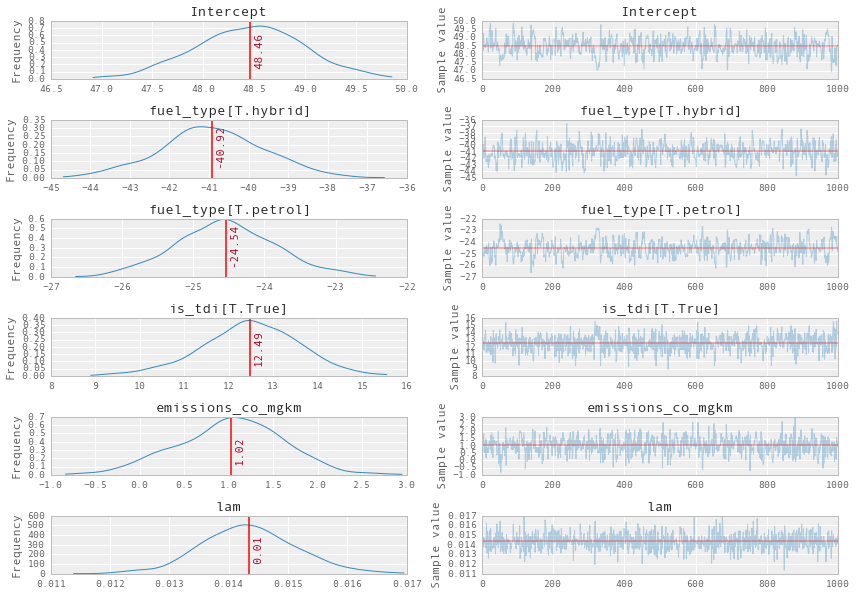

In [15]:
plot_traces(trc_pooled, retain=1000, varnames=rvs_pooled)

---

# Unpooled Model

Include the `mfr` feature values in the dmatrix. Each `mfr` value gets a slope and intercept, basically trained as separate regressions.

$$y_{m} \sim \beta_{m} x_{m} + \epsilon$$

where: $m \in manufacturer$



##### Create design matrices for ease of model spec

In [16]:
# create design matrices for statsmodels
(mx_en_unpooled, mx_ex_unpooled) = pt.dmatrices(fml_pooled, dfs
                                      , return_type='dataframe', NA_action='raise')

mx_ex_unpooled.head()

,Intercept,fuel_type[T.hybrid],fuel_type[T.petrol],is_tdi[T.True],emissions_co_mgkm
0,1,0,1,0,-0.164902
1,1,0,1,0,-0.164902
2,1,0,1,0,0.628196
3,1,0,1,0,0.628196
4,1,0,1,0,-0.164902


In [21]:
with pm.Model() as mdl_unpooled:
   
    # define priors, use Normal for Ridge (sd=100, weakly informative)
    b0 = pm.Normal('b0_intercept', mu=0, sd=100, shape=n_mfr_enc)
    b1a = pm.Normal('b1a_fuel_type[T.hybrid]', mu=0, sd=100, shape=n_mfr_enc)
    b1b = pm.Normal('b1b_fuel_type[T.petrol]', mu=0, sd=100, shape=n_mfr_enc)
    b2 = pm.Normal('b2_is_tdi[T.True]', mu=0, sd=100, shape=n_mfr_enc)
    b3 = pm.Normal('b3_emissions_co_mgkm', mu=0, sd=100, shape=n_mfr_enc)    
    
    # define linear model
    yest = ( b0[dfs['mfr_enc']] +
             b1a[dfs['mfr_enc']] * mx_ex_unpooled['fuel_type[T.hybrid]'] +
             b1b[dfs['mfr_enc']] * mx_ex_unpooled['fuel_type[T.petrol]'] +            
             b2[dfs['mfr_enc']] * mx_ex_unpooled['is_tdi[T.True]'] +
             b3[dfs['mfr_enc']] * mx_ex_unpooled['emissions_co_mgkm'])

    # create MLE: epsilon from HalfCauchy dist and free discrete param on nu  
    epsilon = pm.HalfCauchy('epsilon', beta=10)
#     nu = pm.DiscreteUniform('nu', lower=1, upper=50)
   
    ## Student T likelihood with fixed degrees of freedom nu
    likelihood = pm.StudentT('likelihood', nu=1, mu=yest, sd=epsilon
                             ,observed=dfs[ft_endog])
    
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
      
    trc_unpooled = pm.sample(2000, step=pm.NUTS(), start=start_MAP)

Applied log-transform to epsilon and added transformed epsilon_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 341.3 sec

In [22]:
rvs_unpooled = [rv.name for rv in mdl_unpooled.unobserved_RVs if not re.search('_log',rv.name)]

pm.df_summary(trc_unpooled[-1000:], varnames=rvs_unpooled).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0_intercept__0,17.208719,66.220824,6.288344,-91.022429,152.922065
b0_intercept__1,24.576086,63.639113,5.820907,-96.054707,154.946215
b0_intercept__2,1.161895,63.852585,5.851934,-110.872397,121.461212
b0_intercept__3,-0.480390,32.940475,3.253573,-58.925046,58.627070
b0_intercept__4,23.969783,85.891410,8.342099,-119.719626,218.120756


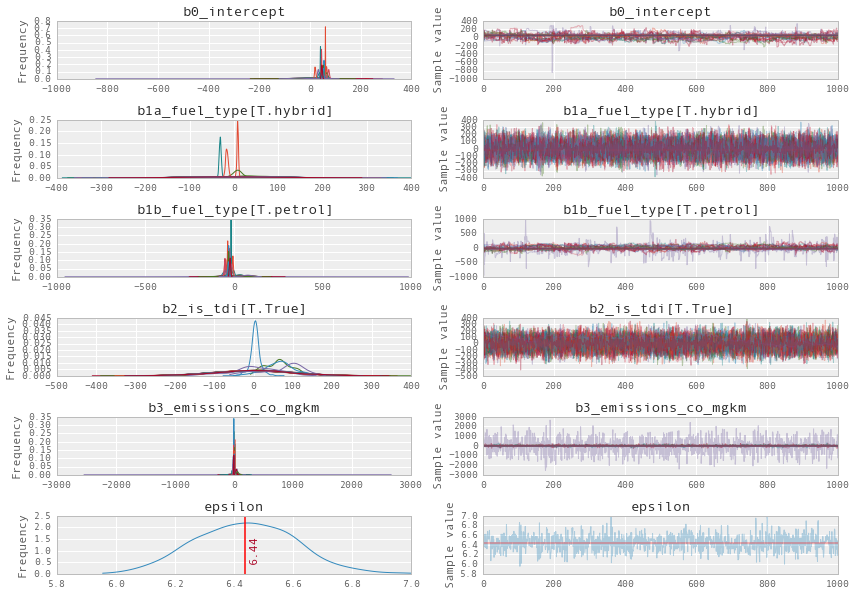

In [23]:
# ax = pm.traceplot(trc_unpooled[-1000:], varnames=rvs_unpooled)
plot_traces(trc_unpooled, retain=1000, varnames=rvs_unpooled)

# Partially-Pooled Model

For simplicity, place partial-pooling on intercept only. This helps us determine a different between manufacturers, all other features constant

In [24]:
with pm.Model() as mdl_partpooled:

    # define hyperpriors for intercept
    b0_mu = pm.Normal('b0_mu', mu=0, sd=100)
    b0_sd = pm.HalfCauchy('b0_sd', beta=10)
   
    # define priors, use Normal for Ridge (sd=100, weakly informative)
    b0 = pm.Normal('b0_mfr', mu=b0_mu, sd=b0_sd, shape=n_mfr_enc)
    b1a = pm.Normal('b1a_fuel_type[T.hybrid]', mu=0, sd=100)
    b1b = pm.Normal('b1b_fuel_type[T.petrol]', mu=0, sd=100)
    b2 = pm.Normal('b2_is_tdi[T.True]', mu=0, sd=100)
    b3 = pm.Normal('b3_emissions_co_mgkm', mu=0, sd=100) 
    
    # define linear model
    yest = ( b0[dfs['mfr_enc']] +
             b1a * mx_ex_unpooled['fuel_type[T.hybrid]'] +
             b1b * mx_ex_unpooled['fuel_type[T.petrol]'] +            
             b2 * mx_ex_unpooled['is_tdi[T.True]'] +
             b3 * mx_ex_unpooled['emissions_co_mgkm'])

    # create MLE: epsilon from HalfCauchy dist and free discrete param on nu  
    epsilon = pm.HalfCauchy('epsilon', beta=10)
#     nu = pm.DiscreteUniform('nu', lower=1, upper=50)
   
    ## Student T likelihood with fixed degrees of freedom nu
    likelihood = pm.StudentT('likelihood', nu=1, mu=yest, sd=epsilon
                             ,observed=dfs[ft_endog])
    
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
      
    trc_partpooled = pm.sample(2000, step=pm.NUTS(), start=start_MAP)

Applied log-transform to b0_sd and added transformed b0_sd_log to model.
Applied log-transform to epsilon and added transformed epsilon_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 31.0 sec

In [25]:
rvs_partpooled = [rv.name for rv in mdl_partpooled.unobserved_RVs 
                  if not re.search('_log',rv.name)]

pm.df_summary(trc_partpooled[-1000:], varnames=rvs_partpooled).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0_mu,47.771534,1.469742,0.069202,44.919871,50.419928
b0_mfr__0,49.999349,2.817950,0.078269,44.462161,55.240117
b0_mfr__1,57.327755,2.643333,0.090460,52.032790,62.363943
b0_mfr__2,50.050069,5.082511,0.168001,40.221295,59.968779
b0_mfr__3,51.969215,1.208012,0.062732,49.675784,54.416307


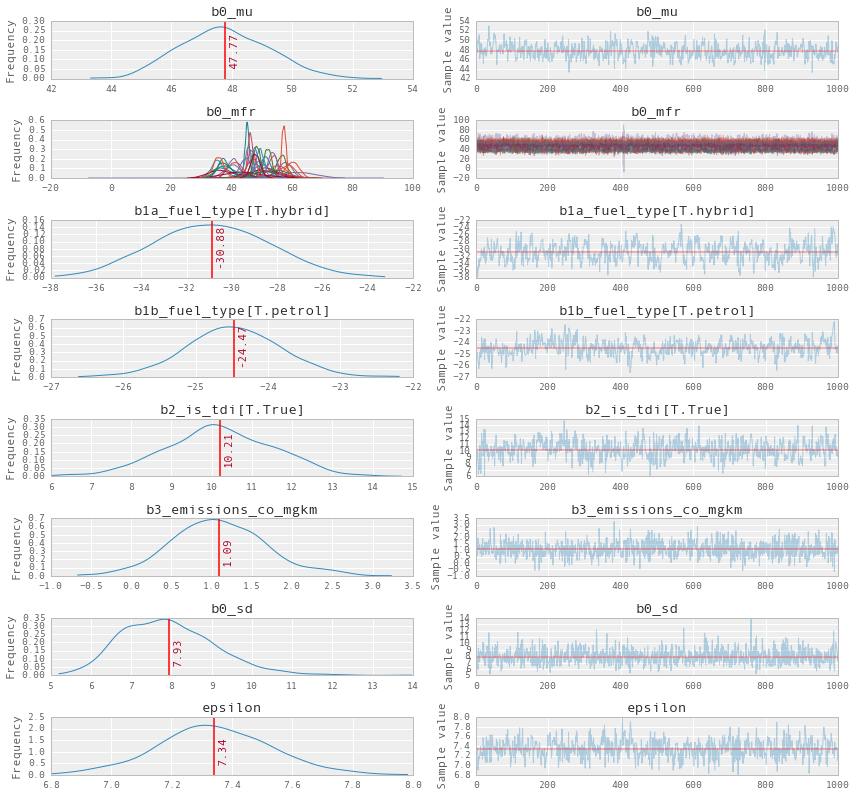

In [26]:
plot_traces(trc_partpooled, retain=1000, varnames=rvs_partpooled)

# Hierarchical Model

Extend the prtial-pooled model above with another layer for `mfr_owner` the manufacturer partent company (and place a partial pooling on that).

This is a true hierarchical model

In [31]:
with pm.Model() as mdl_hier:

    # set constants for convenience
    mfr_owner_enc = T.constant(dfs['mfr_owner_enc'])
    mfr_enc = T.constant(dfs['mfr_enc'])
        
    # define hyperpriors
    b0_mn_mn = pm.Normal('b0_mn_mn', mu=0, sd=100)
    b0_mn_mfr_owner = pm.Normal('b0_mn_mfr_owner', mu=b0_mn_mn
                                ,sd=100, shape=n_mfr_owner_enc)
  
    # define hyperpriors for intercept based on mfr_owner
#     b0_mu = pm.Normal('b0_mu', mu=0, sd=100)
#     b0_sd = pm.HalfCauchy('b0_sd', beta=10)
   
    # define priors, use Normal for Ridge (sd=100, weakly informative)
    # NOTE b0 is created by a very simple regression on b0_mn indexed by mfr_owner
    b0 = pm.Normal('b0_mfr', mu=T.sum(b0_mn_mfr_owner[mfr_owner_enc])
                               ,sd=100, shape=n_mfr_enc)
    b1a = pm.Normal('b1a_fuel_type[T.hybrid]', mu=0, sd=100)
    b1b = pm.Normal('b1b_fuel_type[T.petrol]', mu=0, sd=100)
    b2 = pm.Normal('b2_is_tdi[T.True]', mu=0, sd=100)
    b3 = pm.Normal('b3_emissions_co_mgkm', mu=0, sd=100) 
    
    # define linear model
    yest = ( b0[dfs['mfr_enc']] +
             b1a * mx_ex_unpooled['fuel_type[T.hybrid]'] +
             b1b * mx_ex_unpooled['fuel_type[T.petrol]'] +            
             b2 * mx_ex_unpooled['is_tdi[T.True]'] +
             b3 * mx_ex_unpooled['emissions_co_mgkm'])

    # create MLE: epsilon from HalfCauchy dist and free discrete param on nu  
    epsilon = pm.HalfCauchy('epsilon', beta=10)
#     nu = pm.DiscreteUniform('nu', lower=1, upper=100)
   
    ## Student T likelihood with fixed degrees of freedom nu
    likelihood = pm.StudentT('likelihood', nu=1, mu=yest, sd=epsilon
                             ,observed=dfs[ft_endog])
    
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
      
    # NOTE: uing Metropolis, since NUTS runs incredibly slowly 
    trc_hier = pm.sample(20000, step=pm.Metropolis(), start=start_MAP)

Applied log-transform to epsilon and added transformed epsilon_log to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 31.5 sec

In [32]:
rvs_hier = [rv.name for rv in mdl_hier.unobserved_RVs 
                  if not re.search('_log',rv.name)]

pm.df_summary(trc_hier[-1000:], varnames=rvs_hier).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0_mn_mn,2.275607,21.111023,1.181777,-38.994687,40.581635
b0_mn_mfr_owner__0,6.283864,0.242309,0.023885,5.821513,6.686430
b0_mn_mfr_owner__1,0.673345,0.199753,0.019736,0.334497,1.043491
b0_mn_mfr_owner__2,1.701104,0.262912,0.025998,1.333455,2.224446
b0_mn_mfr_owner__3,-2.123597,0.447529,0.044575,-3.071102,-1.401783


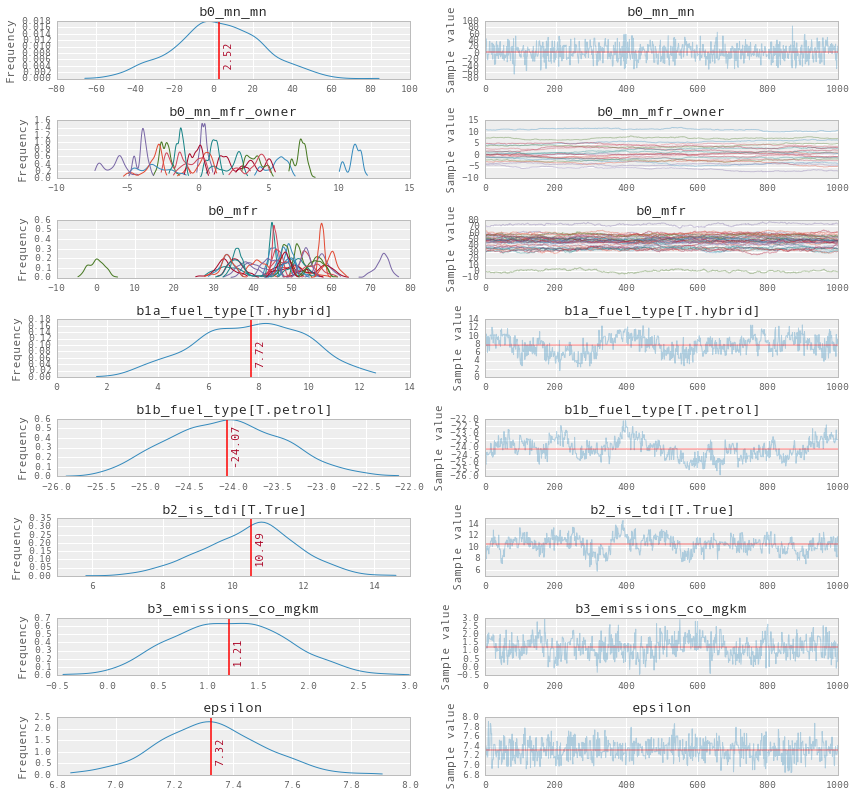

In [35]:
plot_traces(trc_hier[::3], retain=1000, varnames=rvs_hier)

### View forestplot for  `mfr_owner`

In [41]:
mfr_owner_smry = pm.df_summary(trc_hier[-1000:])[1:21]
mfr_owner_smry['mfr_owner'] = dfs['mfr_owner'].unique()
mfr_owner_smry.sort('mean', ascending=True, inplace=True)
mfr_owner_smry['ypos'] = np.arange(20)
mfr_owner_smry['xerr'] = 0

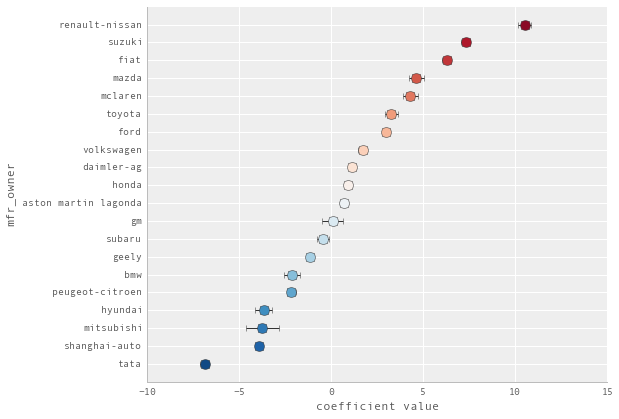

In [42]:
g = sns.FacetGrid(hue='mean', data=mfr_owner_smry, size=6, aspect=1.2
                  ,palette='RdBu_r', ylim=(-1,20))
_ = g.map(plt.errorbar, 'mean', 'ypos', 'xerr', 'sd'
                  ,marker='o', ms=10, mew=0.5, mec='#333333', ecolor='#333333')
_ = g.axes[0][0].set_ylabel('mfr_owner')
_ = g.axes[0][0].set_xlabel('coefficient value')
_ = g.axes[0][0].set_yticks(np.arange(20))
_ = g.axes[0][0].set_yticklabels(mfr_owner_smry['mfr_owner'])

### View forestplot for  `mfr`

In [44]:
mfr_smry = pm.df_summary(trc_hier[-1000:])[21:59]
mfr_smry['mfr'] = dfs['mfr'].unique()
mfr_smry.sort('mean', ascending=True, inplace=True)
mfr_smry['ypos'] = np.arange(38)
mfr_smry['xerr'] = 0

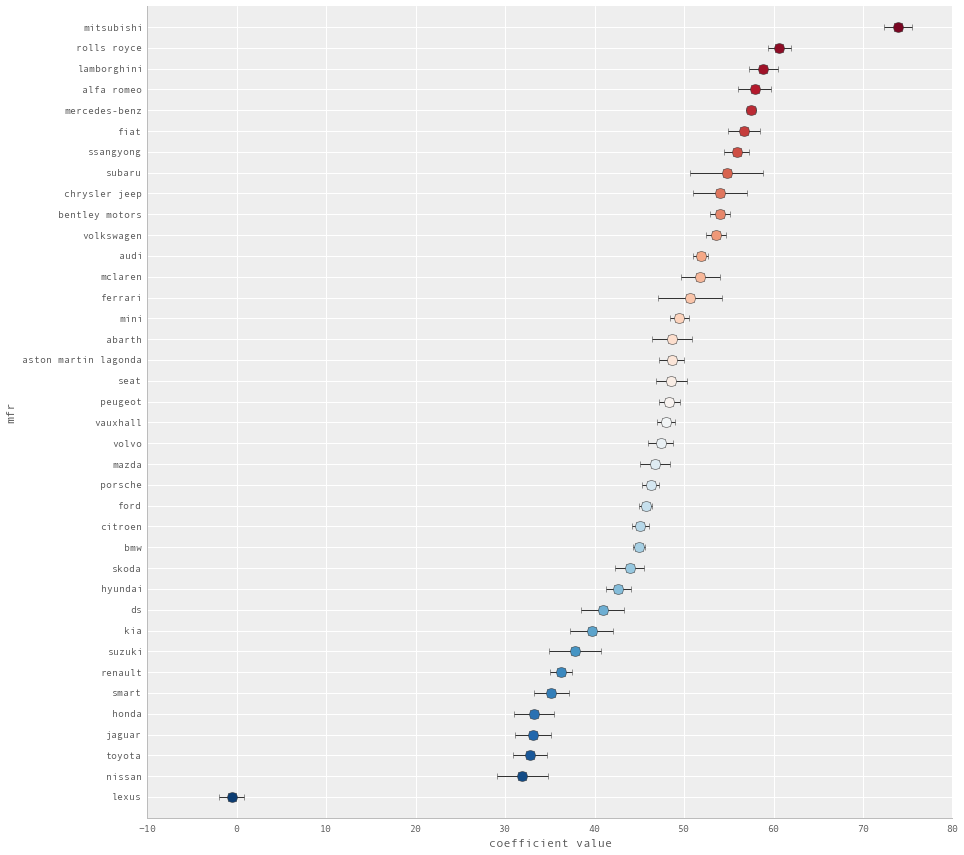

In [45]:
g = sns.FacetGrid(hue='mean', data=mfr_smry, size=12, aspect=1
                  ,palette='RdBu_r', ylim=(-1,38))
_ = g.map(plt.errorbar, 'mean', 'ypos', 'xerr', 'sd'
                  ,marker='o', ms=10, mew=0.5, mec='#333333', ecolor='#333333')
_ = g.axes[0][0].set_ylabel('mfr')
_ = g.axes[0][0].set_xlabel('coefficient value')
_ = g.axes[0][0].set_yticks(np.arange(38))
_ = g.axes[0][0].set_yticklabels(mfr_smry['mfr'])

### Plot groupings of `mfr_owner` and `mfr`

In [46]:
mfr_owner_mean = pm.df_summary(trc_hier[1000:])[1:21]
mfr_owner_mean['mfr_owner'] = dfs['mfr_owner'].unique()
mfr_owner_mean['mfr_owner_idx'] = np.arange(20)
mfr_mean = pm.df_summary(trc_hier[1000:])[21:59]
mfr_mean['mfr'] = dfs['mfr'].unique()
mfr_mean['mfr_idx'] = np.arange(38)

In [82]:
dfg = dfs.groupby(['mfr_owner','mfr']).size().reset_index()
dfg['key'] = dfg[['mfr_owner','mfr']].apply(lambda r: '{} - {}'.format(r[0][:5], r[1]), axis=1)
dfg = pd.merge(dfg, mfr_owner_mean[['mfr_owner','mfr_owner_idx','mean','sd']]
               ,how='left', left_on='mfr_owner', right_on='mfr_owner')
dfg.rename(columns={0:'n','mean':'mean_mfr_owner', 'sd':'sd_mfr_owner'}, inplace=True)

dfg = pd.merge(dfg, mfr_mean[['mfr','mfr_idx','mean','sd']]
               ,how='left', left_on='mfr', right_on='mfr')
dfg.rename(columns={0:'n','mean':'mean_mfr', 'sd':'sd_mfr'}, inplace=True)

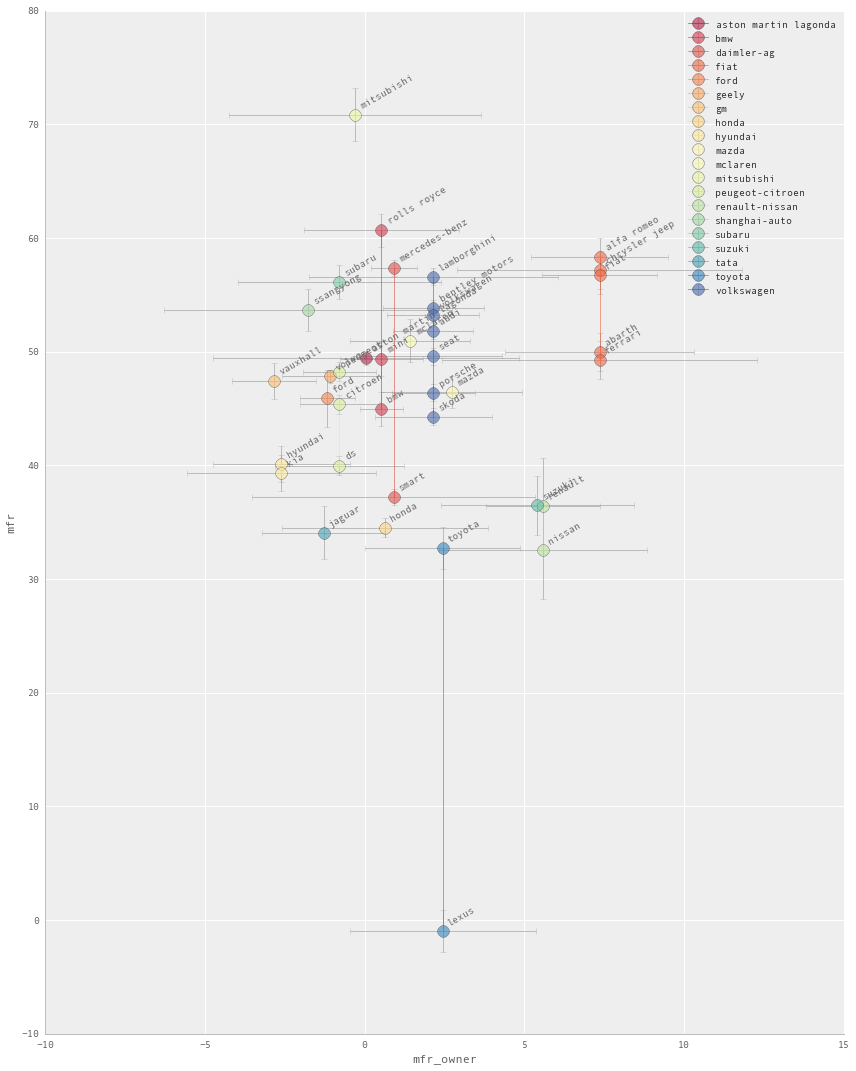

In [97]:
g = sns.FacetGrid(hue='mfr_owner', data=dfg, size=15, aspect=0.8
                    ,legend_out=True, palette='Spectral')#RdYlBu')
_ = g.map(plt.errorbar, 'mean_mfr_owner', 'mean_mfr', 'sd_mfr_owner', 'sd_mfr'
    ,marker='o', ms=12, mew=0.5, mec='#333333', ecolor='#999999', alpha=0.6)
_ = g.axes[0][0].legend()
_ = g.axes[0][0].set_ylabel('mfr')
_ = g.axes[0][0].set_xlabel('mfr_owner')

for i, row in dfg[['key','mean_mfr_owner','mean_mfr']].iterrows():
    _ = g.axes[0][0].annotate(row[0].split(' - ')[1]
                     ,xy=(row[1], row[2]), xycoords='data'
                     ,xytext=(5,5), textcoords='offset points'
                     ,color='#666666', fontsize=10, rotation=30, va='bottom')

---
**&copy; Applied AI Ltd 2016**  
<a href='http://www.applied.ai'>applied.ai</a>